# Objetivo: Regressão no dataset "Real estate valuation" (UCI), usando MLP.
    - Avaliação por validação cruzada k-fold e análise de resíduos.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp
from trabalho_ic_aplicada.models.reg_perceptron import treinar_perceptron_reg, prever_perceptron_reg

2025-08-10 19:28:00.069 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


### Random Search e Avaliação Melhor Caso MLP.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from trabalho_ic_aplicada.models import reg_mlp
# import aux  # supondo que aux.calcular_metricas, etc. estejam em aux.py
import random
import itertools

def cross_val_mlp(X, y, k_fold, layer_sizes, activation, epochs, lr):
    """
    Executa CV para um MLP de 1 camada oculta, retorna média de R2 e todas as curvas de loss.
    """
    fold_r2 = []
    fold_losses = []
    for train_idx, test_idx in k_fold:
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)
        # Normaliza X
        scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
        X_tr_n = scaler.fit_transform(X_tr)
        X_te_n = scaler.transform(X_te)
        # Treina
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)
        # Previsão
        y_pred = reg_mlp.predict_mlp_regression(X_te_n, W, activation, 'linear').reshape(-1,1)
        # R2
        _, _, r2, *_ = aux.calcular_metricas(y_te, y_pred, aux)
        fold_r2.append(r2)
    return np.mean(fold_r2), fold_losses

def grid_search(X, y, k_fold, hidden_units, activations, epochs_list, lrs):
    best = {'score': -np.inf}
    for act in activations:
        for hu in hidden_units:
            for ep in epochs_list:
                for lr in lrs:
                    ls = [X.shape[1], hu, 1]
                    mean_r2, _ = cross_val_mlp(X, y, k_fold, ls, act, ep, lr)
                    print(f"Act={act:<7} HU={hu:2d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")
                    if mean_r2 > best['score']:
                        best.update({
                            'layer_sizes': ls,
                            'activation': act,
                            'epochs': ep,
                            'lr': lr,
                            'score': mean_r2
                        })
    print("\n=== Best config ===")
    print(best)
    return best



def random_search(X, y, k_fold, hidden_units, activations, epochs_list, lrs, n_iter=20, seed=42):
    """
    Executa busca aleatória por hiperparâmetros para o MLP.
    """
    random.seed(seed)
    np.random.seed(seed)

    # Gera todas as combinações possíveis
    all_combinations = list(itertools.product(activations, hidden_units, epochs_list, lrs))
    # Embaralha e pega n combinações aleatórias
    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best = {'score': -np.inf}
    for act, hu, ep, lr in sampled_combinations:
        ls = [X.shape[1], hu, 1]
        mean_r2, _ = cross_val_mlp(X, y, k_fold, ls, act, ep, lr)
        print(f"Act={act:<7} HU={hu:2d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")
        if mean_r2 > best['score']:
            best.update({
                'layer_sizes': ls,
                'activation': act,
                'epochs': ep,
                'lr': lr,
                'score': mean_r2
            })

    print("\n=== Best config ===")
    print(best)
    return best

In [4]:

# 1) Grid search
hidden_units  = [4, 8, 16, 32, 64]
activations   = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
epochs_list   = [100, 200, 300]
learning_rates= [1e-3, 5e-3, 1e-2]

# 1) Random search
best_cfg = random_search(X, y, k_fold,
                         hidden_units, activations,
                         epochs_list, learning_rates,
                         n_iter=60)  # você pode ajustar n_iter

# best_cfg = grid_search(X, y, k_fold,
#                        hidden_units, activations,
#                        epochs_list, learning_rates)

Act=leaky_relu HU=32 Ep=100 LR=0.005 → R²=0.6521
Act=sigmoid HU=32 Ep=100 LR=0.005 → R²=0.6791
Act=sigmoid HU= 4 Ep=300 LR=0.001 → R²=0.6795
Act=tanh    HU=16 Ep=300 LR=0.005 → R²=0.6290
Act=tanh    HU= 8 Ep=300 LR=0.01 → R²=0.6228
Act=tanh    HU= 8 Ep=200 LR=0.001 → R²=0.6613
Act=sigmoid HU=32 Ep=300 LR=0.01 → R²=0.6713
Act=sigmoid HU=16 Ep=300 LR=0.01 → R²=0.6644
Act=leaky_relu HU= 4 Ep=200 LR=0.005 → R²=0.6707
Act=sigmoid HU=16 Ep=200 LR=0.005 → R²=0.6903
Act=leaky_relu HU= 8 Ep=300 LR=0.005 → R²=0.6810
Act=relu    HU=16 Ep=100 LR=0.001 → R²=0.6695
Act=sigmoid HU= 4 Ep=300 LR=0.01 → R²=0.6556
Act=sigmoid HU= 4 Ep=300 LR=0.005 → R²=0.6682
Act=sigmoid HU=16 Ep=200 LR=0.01 → R²=0.6835
Act=tanh    HU= 8 Ep=100 LR=0.005 → R²=0.6000
Act=tanh    HU= 8 Ep=200 LR=0.01 → R²=0.6540
Act=relu    HU=64 Ep=200 LR=0.001 → R²=0.6643
Act=leaky_relu HU=16 Ep=100 LR=0.005 → R²=0.6648
Act=leaky_relu HU=64 Ep=300 LR=0.001 → R²=0.6907
Act=leaky_relu HU= 4 Ep=300 LR=0.01 → R²=0.6867
Act=tanh    HU= 4 Ep=20


=== Best config ===
{'score': np.float64(0.6907358683810801), 'layer_sizes': [5, 64, 1], 'activation': 'leaky_relu', 'epochs': 300, 'lr': 0.001}

Erro Quadrático Médio (EQM): 61.8804 ± 49.3895
Raiz do Erro Quadrático Médio (REQM): 7.4199 ± 2.6126
Hit rate 20%: 0.7822 ± 0.0778
Hit rate 10%: 0.4815 ± 0.0835

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8505 ± 0.0134
Correlação Média (Teste): 0.8383 ± 0.0789
Coeficiente de Determinação (R²): 0.6854 ± 0.1337

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8381, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8254, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


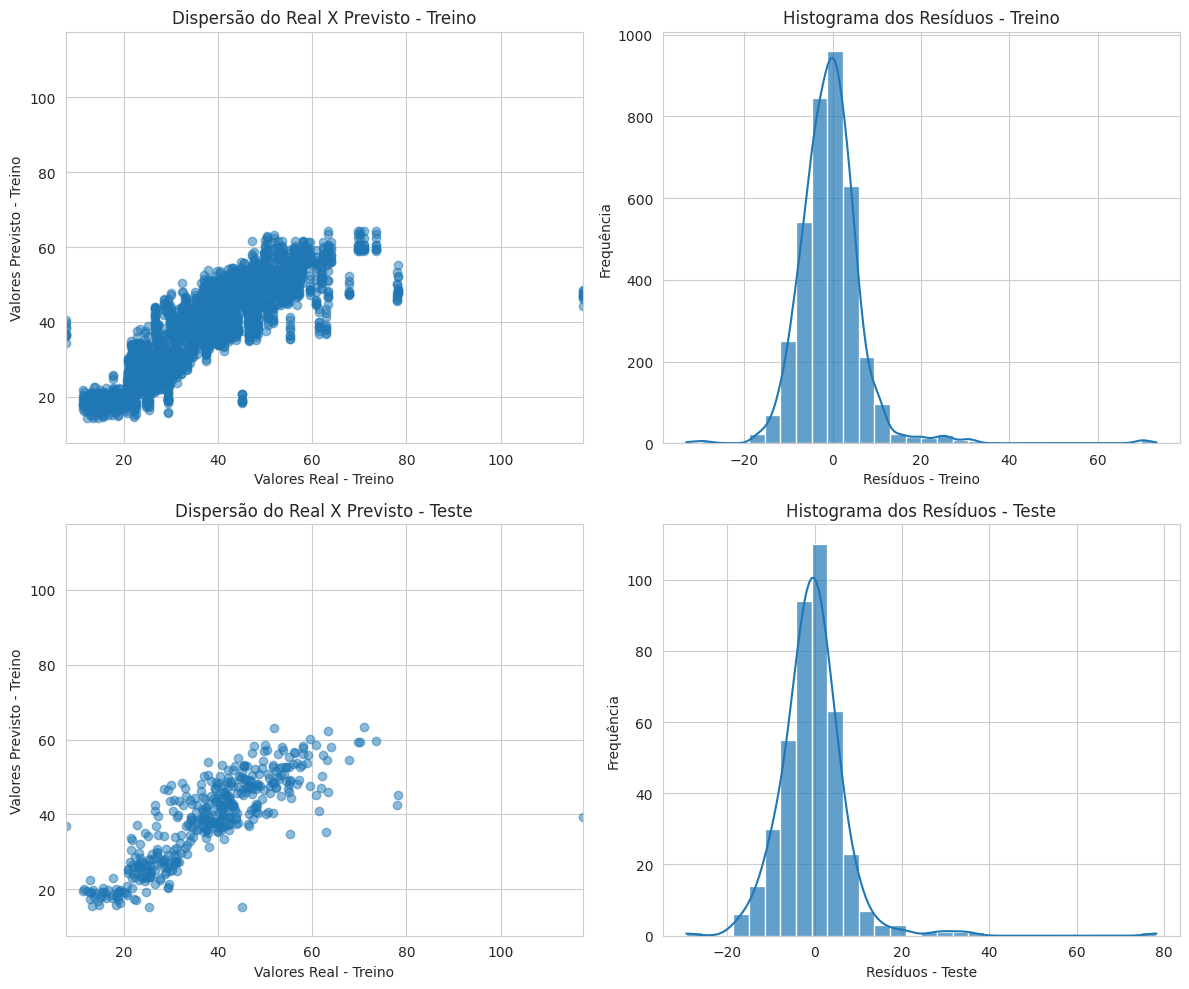

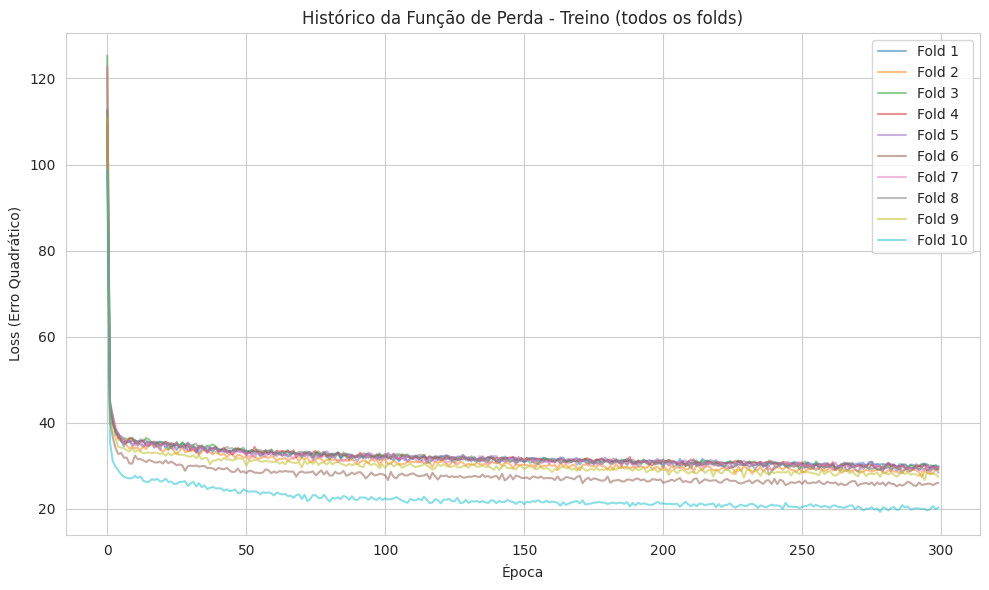

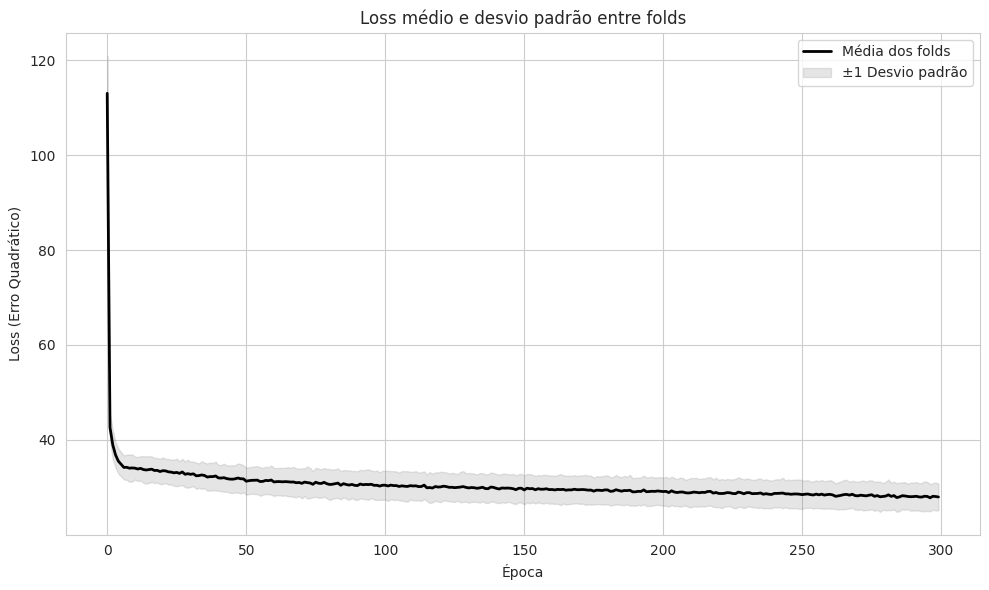

In [9]:

# 2) Treino final com CV para coletar tudo
ls   = best_cfg['layer_sizes']
act  = best_cfg['activation']
ep   = best_cfg['epochs']
lr   = best_cfg['lr']

all_train_losses = []
y_tr_all, y_trp_all = [], []
y_te_all, y_tep_all   = [], []
cor_tr, cor_te = [], []

eqms, reqms, r2s, h20, h10 = [], [], [], [], []


for train_idx, test_idx in k_fold:
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)
    scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
    X_tr_n = scaler.fit_transform(X_tr)
    X_te_n = scaler.transform(X_te)

    W, loss_hist = reg_mlp.train_mlp_regression(
        X_tr_n, y_tr, layer_sizes=ls,
        epochs=ep, eta_i=lr, eta_f=lr,
        hidden_activation=act, output_activation='linear',
        verbose=False
    )
    all_train_losses.append(loss_hist)

    y_trp = reg_mlp.predict_mlp_regression(X_tr_n, W, act, 'linear').reshape(-1,1)
    y_tep = reg_mlp.predict_mlp_regression(X_te_n, W, act, 'linear').reshape(-1,1)

    cor_tr.append(np.corrcoef(y_tr.flatten(), y_trp.flatten())[0,1])
    cor_te.append(np.corrcoef(y_te.flatten(), y_tep.flatten())[0,1])

    eqm, reqm, r2, hit_20, hit_10, _ = aux.calcular_metricas(y_te, y_tep, aux)
    eqms.append(eqm)
    reqms.append(reqm)
    r2s.append(r2)
    h20.append(hit_20)
    h10.append(hit_10)


    y_tr_all .extend(y_tr.flatten())
    y_trp_all.extend(y_trp.flatten())
    y_te_all .extend(y_te.flatten())
    y_tep_all.extend(y_tep.flatten())

# 3) Métricas finais
aux.imprimir_metricas(eqms, reqms, r2s, h20, h10)
aux.imprimir_correlacoes(cor_tr, cor_te, r2s)
aux.analisar_residuos(
    np.array(y_tr_all), np.array(y_trp_all),
    np.array(y_te_all), np.array(y_tep_all),
    aux, titulo="MLP Final"
)

# 4) Plots de loss
aux.plot_folds_loss(all_train_losses)
